In [1]:
import torch
import torch.nn as nn
import torchvision

In [2]:
def init_cnn(module):
  if type(module) == nn.Linear or type(module) == nn.Conv2d:
    nn.init.xavier_uniform_(module.weight)

In [19]:
n_classes = 10
n_epochs = 50
batch_size = 256
lr = 1e-4

In [26]:
class LeNet(nn.Module):
  def __init__(self, n_classes):
    super(LeNet, self).__init__()
    self.conv_layer1 = nn.Sequential(
        nn.LazyConv2d(out_channels=6, kernel_size=5, padding=2), 
        nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
    )
    self.conv_layer2 = nn.Sequential(
        nn.LazyConv2d(out_channels=16, kernel_size=5), 
        nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
    )
    self.flatten = nn.Flatten()
    self.linear_layer1 = nn.Sequential(
        nn.LazyLinear(120), nn.Sigmoid()
    )
    self.linear_layer2 = nn.Sequential(
        nn.LazyLinear(84), nn.Sigmoid()
    )
    self.linear_layer3 = nn.LazyLinear(n_classes)
  def forward(self, x):
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.flatten(x)
    x = self.linear_layer1(x)
    x = self.linear_layer2(x)
    x = self.linear_layer3(x)
    return x

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} of training LeNet'.format(device))
model = LeNet(10)
model.to(device)

Using cuda of training LeNet


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


LeNet(
  (conv_layer1): Sequential(
    (0): LazyConv2d(0, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv_layer2): Sequential(
    (0): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_layer1): Sequential(
    (0): LazyLinear(in_features=0, out_features=120, bias=True)
    (1): Sigmoid()
  )
  (linear_layer2): Sequential(
    (0): LazyLinear(in_features=0, out_features=84, bias=True)
    (1): Sigmoid()
  )
  (linear_layer3): LazyLinear(in_features=0, out_features=10, bias=True)
)

In [22]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  

training_steps = len(train_dataloader)
val_steps = len(val_dataloader)

training_losses = []
val_losses = []
val_accs = []

In [29]:
print(training_steps)
print(val_steps)

469
79


In [30]:
print('Start Training...\n')
for epoch in range(n_epochs):
    total_training_loss = 0
    model.train()
    for idx, (X_train, y_train) in enumerate(train_dataloader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        total_training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    training_loss = total_training_loss / training_steps
    training_losses.append(training_loss)

    print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {training_loss:.3f}')

    with torch.no_grad():
        model.eval()
        n_correct_preds = 0
        n_val_samples = 0
        total_val_loss = 0
        for idx, (X_val, y_val) in enumerate(val_dataloader):
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            total_val_loss += loss.item()

            y_pred_max, y_pred_max_idx = torch.max(y_pred, 1)
            n_val_samples += y_pred.size(0)
            n_correct_preds += (y_val == y_pred_max_idx).sum().item()

        val_acc = n_correct_preds / n_val_samples
        val_loss = total_val_loss / val_steps
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.3f}\n')

print('Training Completed')

Start Training...

Epoch [1/50], Training Loss: 2.302
Val Loss: 2.292, Val Accuracy: 0.207

Epoch [2/50], Training Loss: 2.079
Val Loss: 1.735, Val Accuracy: 0.463

Epoch [3/50], Training Loss: 1.509
Val Loss: 1.342, Val Accuracy: 0.555

Epoch [4/50], Training Loss: 1.241
Val Loss: 1.158, Val Accuracy: 0.582

Epoch [5/50], Training Loss: 1.098
Val Loss: 1.050, Val Accuracy: 0.605

Epoch [6/50], Training Loss: 1.010
Val Loss: 0.982, Val Accuracy: 0.621

Epoch [7/50], Training Loss: 0.953
Val Loss: 0.935, Val Accuracy: 0.648

Epoch [8/50], Training Loss: 0.911
Val Loss: 0.897, Val Accuracy: 0.651

Epoch [9/50], Training Loss: 0.874
Val Loss: 0.864, Val Accuracy: 0.675

Epoch [10/50], Training Loss: 0.842
Val Loss: 0.835, Val Accuracy: 0.684

Epoch [11/50], Training Loss: 0.814
Val Loss: 0.813, Val Accuracy: 0.705

Epoch [12/50], Training Loss: 0.790
Val Loss: 0.792, Val Accuracy: 0.709

Epoch [13/50], Training Loss: 0.769
Val Loss: 0.772, Val Accuracy: 0.711

Epoch [14/50], Training Loss

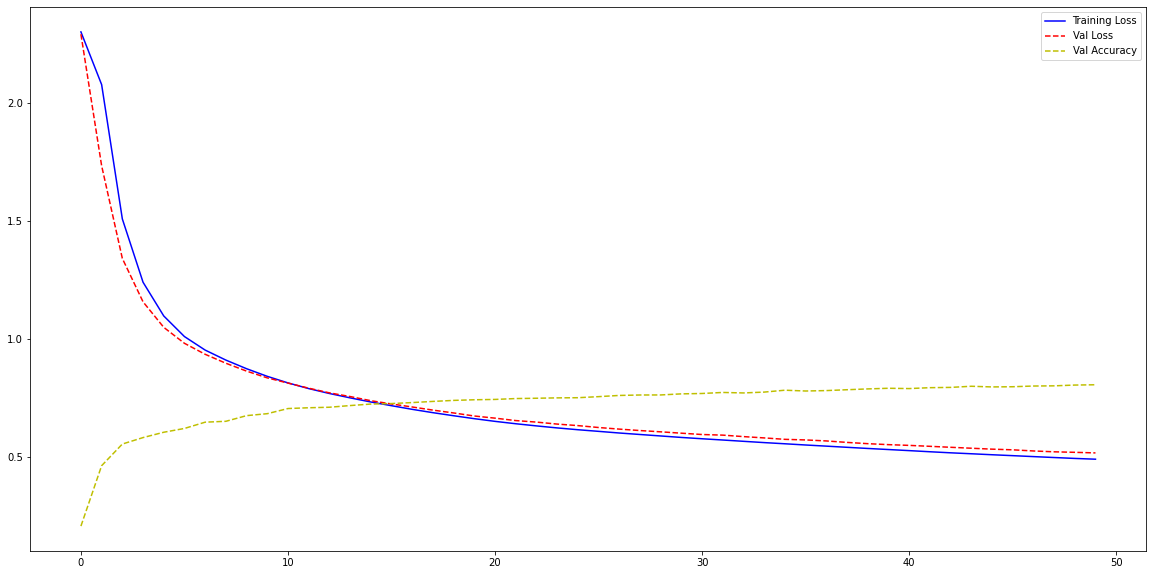

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(training_losses, c='blue', label='Training Loss')
plt.plot(val_losses, c='r', linestyle='--', label='Val Loss')
plt.plot(val_accs, c='y', linestyle='--', label='Val Accuracy')
plt.legend(loc='upper right')